In [1]:
%reset
%matplotlib inline
import networkx as nx
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# README

## Functions:
#### run_model
- input: adjacency matrix
- output: time series for all nodes

#### gen_models
- input: none
- output: results for all possible models

## Data:

#### POModel:
- Phase Oscillator Model

In [41]:
class POModel:
    def __init__(self,A, dt = .05, K=1):
        self.G = nx.from_numpy_matrix(A) #Graph
        self.states = np.matrix([[0],[0],[0],[0],[0],[0]]) +  np.random.uniform(0,1,size=(6,1))#memory of phases
        self.w = np.matrix(np.matrix([[13],[13],[13],[13],[13],[13]])) + np.random.normal(0,2,size=(6,1)) #initial intrinsic freq.
        self.t = 0 #time
        self.dt = dt #time step
        self.K = K
    
    #Kuramoto differential equation
    def phase_dev(self,phase):
        D = (nx.incidence_matrix(self.G, oriented = True)).todense() #incidence
        N = np.random.normal(0, 10, [len(D[0]), 1])
        K = self.K
        return self.w - K * D * np.sin(D.T * self.states[:,-1]) / len(self.G) + N

       
    # 4th order Runge-Kutta approximation
    def step(self):
        k1 = self.phase_dev(self.states[:,-1])*self.dt
        k2 = self.phase_dev(self.states[:,-1]+ .5*k1)*self.dt
        k3 = self.phase_dev(self.states[:,-1]+ .5*k2)*self.dt
        k4 = self.phase_dev(self.states[:,-1]+ k3)*self.dt
        new_state = self.states[:,-1] + (k1+ 2*k2 + 2*k3 + k4)/6
        new_state = new_state % (2 * np.pi)
        self.t += self.dt
        self.states = np.hstack((self.states,new_state))
  

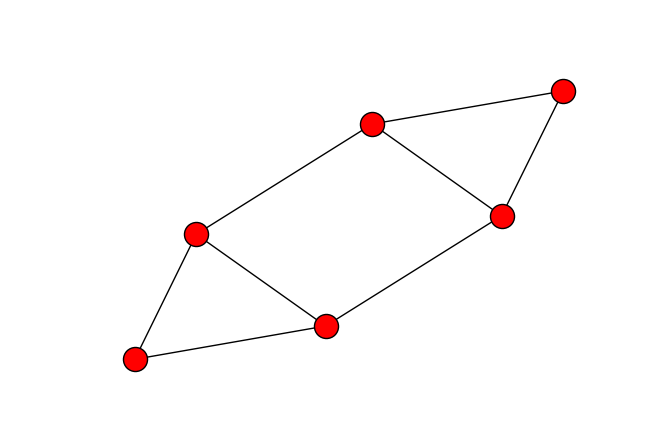

In [39]:
nodes = [1,2,3,4,5,6]
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from([(1,2),(2,3),(1,3),(3,4),(4,5),(4,6),(5,6),(1,6)])

#Quick plot of G
nx.draw(G)

A = nx.to_numpy_matrix(G)

In [42]:
def run_model(A, t = 10,K=1):
    P = POModel(A)
    for ts in range(0,int(t/P.dt)):
        P.step()
    return P

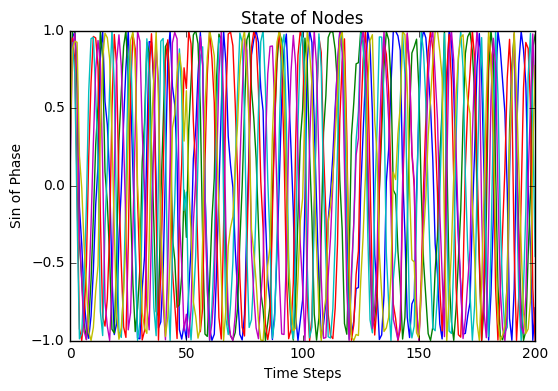

In [43]:
def state_course(A, time = 10):
    P = run_model(A,time,K=100)
            
    plt.figure()
    plt.plot(np.sin(P.states.T))
    plt.xlabel('Time Steps')
    plt.ylabel('Sin of Phase')
    plt.title('State of Nodes')
    plt.xlim((0,int(time/P.dt)))
    plt.show()
state_course(A)

### Assessing phase difference over the timecourse
Here, we want to find the mean phase difference between all pairwise channels

We'll plot this as a stacked gaussian


In [20]:
def gen_models(A, time = 1):
    list_models = []
    list_models.append((A,run_model(A,time).states))
    for i in range(6):
        for j in range(i):
            if A[i,j] != 0:
                B = A.copy()
                B[i,j] = 0
                B[j,i] = 0
                list_models.append((B,run_model(B,time).states))
                B = A.copy()
                B[i,j] = 10
                B[j,i] = 10
                list_models.append((B,run_model(B,time).states))
    return list_models
p = gen_models(A)

### Notes
- Needs some variation in intrinsic frequencies (self.w) , or they are useless (shifting frame, where w = 0) - probably better to gaussian distribution
- R curve shows measure of synchrony, isn't linear: must decide on a "medium synchrony" K value
- Might get better behavior with uniformly distributed phase in the beginning
- Decide on appropriate noise level
